## Importing the dataset

In [25]:
import pandas as pd

# Load the dataset
file_path = 'ecommerce_product_dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()


,ProductID,ProductName,Category,Price,Rating,NumReviews,StockQuantity,Discount,Sales,DateAdded,City
0,1,Headphones,Electronics,400.31,1.7,3772,20,0.08,466,2023-11-10,Albuquerque
1,2,Headphones,Electronics,235.03,2.3,2919,663,0.33,1332,2023-09-28,Queens
2,3,Smartwatch,Electronics,417.90,1.8,1184,459,0.31,252,2023-10-20,Austin
3,4,Smartphone,Electronics,152.70,3.4,2047,475,0.49,1806,2023-12-05,Dallas
4,5,Laptop,Electronics,394.74,1.8,1267,831,0.23,1508,2023-08-10,Tucson


In [26]:
# Check the structure and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ProductID      1000 non-null   int64  
 1   ProductName    1000 non-null   object 
 2   Category       1000 non-null   object 
 3   Price          1000 non-null   float64
 4   Rating         1000 non-null   float64
 5   NumReviews     1000 non-null   int64  
 6   StockQuantity  1000 non-null   int64  
 7   Discount       1000 non-null   float64
 8   Sales          1000 non-null   int64  
 9   DateAdded      1000 non-null   object 
 10  City           1000 non-null   object 
dtypes: float64(3), int64(4), object(4)
memory usage: 86.1+ KB


In [27]:
#Check for missing values
data.isnull().sum()

ProductID        0
ProductName      0
Category         0
Price            0
Rating           0
NumReviews       0
StockQuantity    0
Discount         0
Sales            0
DateAdded        0
City             0
dtype: int64

In [28]:
# Basic statistics
data.describe()

,ProductID,Price,Rating,NumReviews,StockQuantity,Discount,Sales
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,253.77551,3.025600,2498.753000,495.395000,0.251640,1011.037000
std,288.819436,141.40362,1.151004,1463.241871,292.799253,0.146455,582.113466
min,1.000000,10.11000,1.000000,3.000000,0.000000,0.000000,0.000000
25%,250.750000,133.09250,2.100000,1201.750000,241.750000,0.130000,502.000000
50%,500.500000,251.31000,3.100000,2476.000000,505.000000,0.250000,998.000000
75%,750.250000,375.82750,4.000000,3797.500000,743.500000,0.380000,1540.000000
max,1000.000000,499.74000,5.000000,4994.000000,993.000000,0.500000,1997.000000


## 2: Data Preprocessing

In [29]:
from sklearn.preprocessing import MinMaxScaler

# Fill missing values if any (example: forward fill)
data.fillna(method='ffill', inplace=True)

# Normalize the price column for similarity calculations
scaler = MinMaxScaler()
data['NormalizedPrice'] = scaler.fit_transform(data[['Price']])

C:\Users\DANIEL\AppData\Local\Temp\ipykernel_265092\1552930816.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


## 3. Exploratory Data Analysis (EDA)

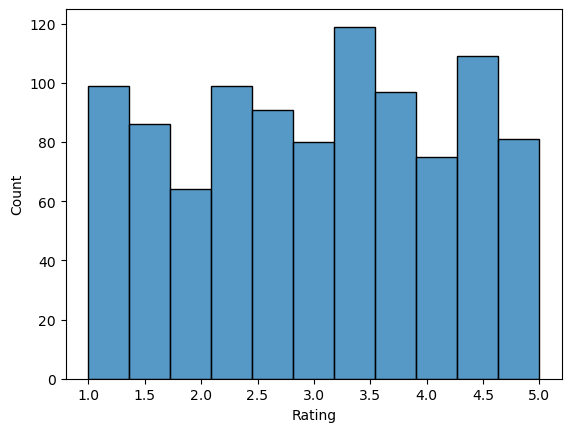

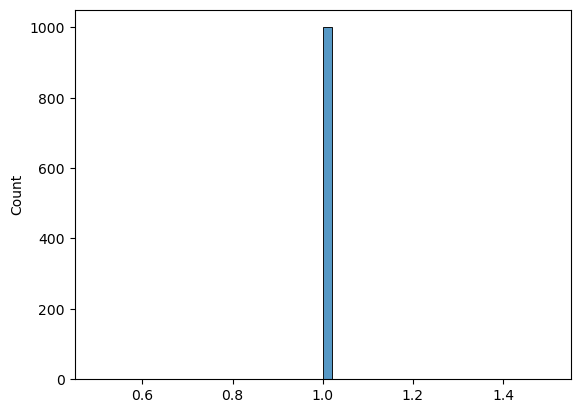

In [4]:
# Visualize data distribution
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting the distribution of ratings or user interactions
sns.histplot(data['Rating'], kde=False)
plt.show()
# Plotting the number of interactions per user
user_interactions = data.groupby('ProductID').size()
sns.histplot(user_interactions, bins=50, kde=False)
plt.show()

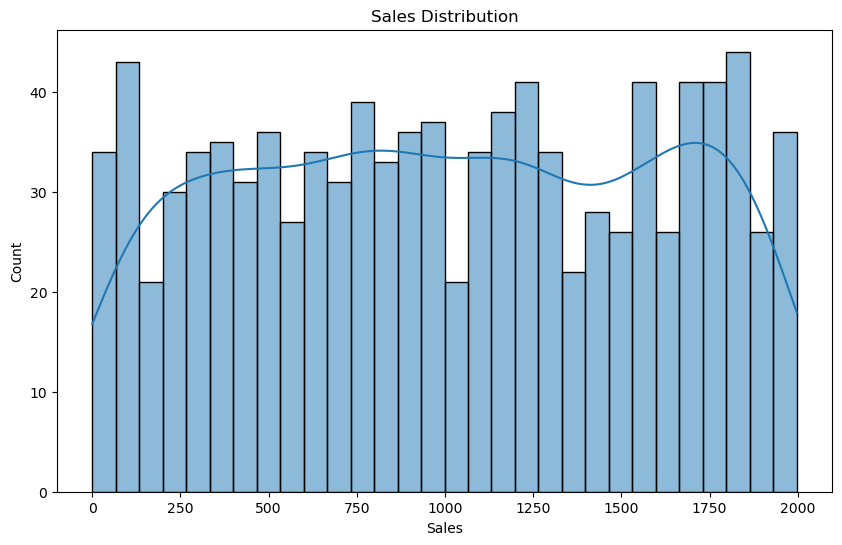

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot sales distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['Sales'], bins=30, kde=True)
plt.title('Sales Distribution')
plt.show()


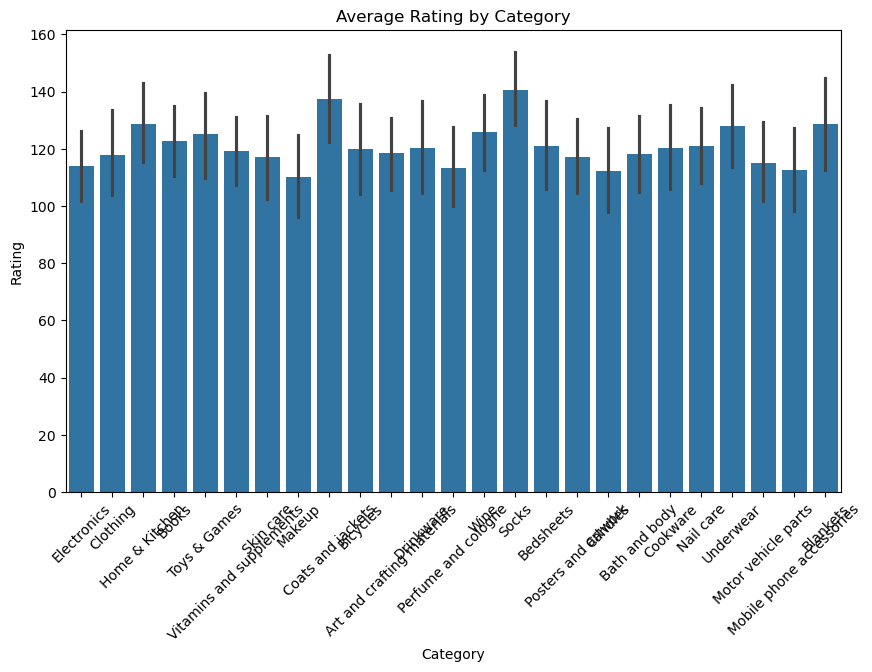

In [31]:
# Plot average rating by category
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Rating', data=data, estimator=sum)
plt.title('Average Rating by Category')
plt.xticks(rotation=45)
plt.show()

## 4: Define Recommendation Strategies

In [32]:
def get_popular_products(data, top_n=10):
    # Sort products by sales in descending order
    popular_products = data.sort_values(by='Sales', ascending=False)
    return popular_products.head(top_n)[['ProductID', 'ProductName', 'Sales']]

# Get top 10 popular products
top_popular_products = get_popular_products(data)
print("Top Popular Products:")
print(top_popular_products)

Top Popular Products:
     ProductID       ProductName  Sales
943        944  Screen Protector   1997
430        431        Sketchbook   1995
624        625       Silk Sheets   1991
931        932           Earbuds   1984
614        615      Linen Sheets   1983
741        742        Body Scrub   1983
240        241         Sunscreen   1981
280        281           Mascara   1979
200        201          Fish Oil   1978
18          19        Headphones   1976


### a) Content-Based Filtering

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendations(data, product_id, top_n=5):
    # Create a feature matrix using 'Category' and 'NormalizedPrice'
    feature_matrix = pd.get_dummies(data['Category'])
    feature_matrix['Price'] = data['NormalizedPrice']

    # Compute cosine similarity between products
    similarity_matrix = cosine_similarity(feature_matrix)

    # Get index of the product
    product_idx = data.index[data['ProductID'] == product_id].tolist()[0]

    # Get similarity scores for the given product
    similarity_scores = list(enumerate(similarity_matrix[product_idx]))

    # Sort the scores and get the top N similar products
    similar_products = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    # Get product details for similar products
    recommended_products = [data.iloc[i[0]][['ProductID', 'ProductName']] for i in similar_products]

    return recommended_products

# Example: Recommend similar products for ProductID 1
product_id = 1
similar_products = content_based_recommendations(data, product_id)
print(f"Products similar to ProductID {product_id}:")
for prod in similar_products:
    print(prod)


Products similar to ProductID 1:
ProductID              20
ProductName    Smartwatch
Name: 19, dtype: object
ProductID           5
ProductName    Laptop
Name: 4, dtype: object
ProductID              29
ProductName    Headphones
Name: 28, dtype: object
ProductID               3
ProductName    Smartwatch
Name: 2, dtype: object
ProductID              36
ProductName    Smartwatch
Name: 35, dtype: object


### b) Collaborative Filtering (Item-Based)

In [34]:
def collaborative_filtering_recommendations(data, product_id, top_n=5):
    # Create a user-product matrix
    user_product_matrix = pd.pivot_table(data, index='ProductID', values='Sales', aggfunc='sum').fillna(0)

    # Compute cosine similarity between products
    similarity_matrix = cosine_similarity(user_product_matrix)

    # Get index of the product
    product_idx = data.index[data['ProductID'] == product_id].tolist()[0]

    # Get similarity scores for the given product
    similarity_scores = list(enumerate(similarity_matrix[product_idx]))

    # Sort the scores and get the top N similar products
    similar_products = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    # Get product details for similar products
    recommended_products = [data.iloc[i[0]][['ProductID', 'ProductName']] for i in similar_products]

    return recommended_products

# Example: Recommend products using collaborative filtering for ProductID 1
collab_similar_products = collaborative_filtering_recommendations(data, product_id)
print(f"Collaborative Filtering recommendations for ProductID {product_id}:")
for prod in collab_similar_products:
    print(prod)


Collaborative Filtering recommendations for ProductID 1:
ProductID               2
ProductName    Headphones
Name: 1, dtype: object
ProductID               3
ProductName    Smartwatch
Name: 2, dtype: object
ProductID               4
ProductName    Smartphone
Name: 3, dtype: object
ProductID           5
ProductName    Laptop
Name: 4, dtype: object
ProductID               6
ProductName    Headphones
Name: 5, dtype: object


## 5: Evaluate the Recommendation System

## 6: Deployment

In [3]:
from flask import Flask, request, jsonify
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

app = Flask(__name__)

# Load and preprocess the dataset
data = pd.read_csv('ecommerce_product_dataset.csv')

# Data Preprocessing
data.ffill(inplace=True)  # Use ffill() directly to forward fill missing values

scaler = MinMaxScaler()
data['NormalizedPrice'] = scaler.fit_transform(data[['Price']])

def get_popular_products(data, top_n=10):
    popular_products = data.sort_values(by='Sales', ascending=False)
    return popular_products.head(top_n)[['ProductID', 'ProductName', 'Sales']].to_dict(orient='records')

def content_based_recommendations(data, product_id, top_n=5):
    feature_matrix = pd.get_dummies(data['Category'])
    feature_matrix['Price'] = data['NormalizedPrice']
    similarity_matrix = cosine_similarity(feature_matrix)
    product_idx = data.index[data['ProductID'] == product_id].tolist()[0]
    similarity_scores = list(enumerate(similarity_matrix[product_idx]))
    similar_products = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    recommended_products = [data.iloc[i[0]][['ProductID', 'ProductName']].to_dict() for i in similar_products]
    return recommended_products

def collaborative_filtering_recommendations(data, product_id, top_n=5):
    user_product_matrix = pd.pivot_table(data, index='ProductID', values='Sales', aggfunc='sum').fillna(0)
    similarity_matrix = cosine_similarity(user_product_matrix)
    product_idx = data.index[data['ProductID'] == product_id].tolist()[0]
    similarity_scores = list(enumerate(similarity_matrix[product_idx]))
    similar_products = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    recommended_products = [data.iloc[i[0]][['ProductID', 'ProductName']].to_dict() for i in similar_products]
    return recommended_products

@app.route('/recommend/popular', methods=['GET'])
def recommend_popular():
    top_n = int(request.args.get('top_n', 10))
    popular_products = get_popular_products(data, top_n=top_n)
    return jsonify(popular_products)

@app.route('/recommend/content', methods=['GET'])
def recommend_content():
    product_id = int(request.args.get('product_id'))
    top_n = int(request.args.get('top_n', 5))
    recommendations = content_based_recommendations(data, product_id, top_n=top_n)
    return jsonify(recommendations)

@app.route('/recommend/collaborative', methods=['GET'])
def recommend_collaborative():
    product_id = int(request.args.get('product_id'))
    top_n = int(request.args.get('top_n', 5))
    recommendations = collaborative_filtering_recommendations(data, product_id, top_n=top_n)
    return jsonify(recommendations)

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'


 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\DANIEL\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [24]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.read_csv('ecommerce_product_dataset.csv')

def get_popular_products(data, top_n=10):
    popular_products = data.sort_values(by='Sales', ascending=False)
    return popular_products.head(top_n)[['ProductID', 'ProductName', 'Sales']]

def content_based_recommendations(data, product_id, top_n=5):
    scaler = MinMaxScaler()
    data['NormalizedPrice'] = scaler.fit_transform(data[['Price']])
    feature_matrix = pd.get_dummies(data['Category'])
    feature_matrix['Price'] = data['NormalizedPrice']
    similarity_matrix = cosine_similarity(feature_matrix)
    product_idx = data.index[data['ProductID'] == product_id].tolist()[0]
    similarity_scores = list(enumerate(similarity_matrix[product_idx]))
    similar_products = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    recommended_products = [data.iloc[i[0]][['ProductID', 'ProductName']] for i in similar_products]
    return recommended_products

def collaborative_filtering_recommendations(data, product_id, top_n=5):
    user_product_matrix = pd.pivot_table(data, index='ProductID', values='Sales', aggfunc='sum').fillna(0)
    similarity_matrix = cosine_similarity(user_product_matrix)
    product_idx = data.index[data['ProductID'] == product_id].tolist()[0]
    similarity_scores = list(enumerate(similarity_matrix[product_idx]))
    similar_products = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    recommended_products = [data.iloc[i[0]][['ProductID', 'ProductName']] for i in similar_products]
    return recommended_products

# Get top 10 popular products
top_popular_products = get_popular_products(data)
print("Top Popular Products:")
print(top_popular_products)

# Example: Recommend similar products for ProductID 1
product_id = 1
similar_products = content_based_recommendations(data, product_id)
print(f"Products similar to ProductID {product_id}:")
for prod in similar_products:
    print(prod)

# Example: Recommend products using collaborative filtering for ProductID 1
collab_similar_products = collaborative_filtering_recommendations(data, product_id)
print(f"Collaborative Filtering recommendations for ProductID {product_id}:")
for prod in collab_similar_products:
    print(prod)


Top Popular Products:
     ProductID       ProductName  Sales
943        944  Screen Protector   1997
430        431        Sketchbook   1995
624        625       Silk Sheets   1991
931        932           Earbuds   1984
614        615      Linen Sheets   1983
741        742        Body Scrub   1983
240        241         Sunscreen   1981
280        281           Mascara   1979
200        201          Fish Oil   1978
18          19        Headphones   1976
Products similar to ProductID 1:
ProductID              20
ProductName    Smartwatch
Name: 19, dtype: object
ProductID           5
ProductName    Laptop
Name: 4, dtype: object
ProductID              29
ProductName    Headphones
Name: 28, dtype: object
ProductID               3
ProductName    Smartwatch
Name: 2, dtype: object
ProductID              36
ProductName    Smartwatch
Name: 35, dtype: object
Collaborative Filtering recommendations for ProductID 1:
ProductID               2
ProductName    Headphones
Name: 1, dtype: object
Pro